In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# Set the random seed for reproducibility

from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

In [3]:
file_path = Path("aapl.csv")
aapl_df = pd.read_csv(file_path, index_col="Date", parse_dates=True, infer_datetime_format=True)
aapl_df.dropna(inplace=True)
aapl_df.sort_index(inplace=True)
aapl_df.head(30)

,Open,High,Low,Close,Volume
Date,,,,,
2002-06-03,0.417678,0.418750,0.403214,0.409107,235110400
2002-06-04,0.408571,0.411428,0.396071,0.406785,347900000
2002-06-05,0.407678,0.408750,0.399107,0.405714,277082400
2002-06-06,0.410000,0.414821,0.393571,0.395714,260064000
2002-06-07,0.388571,0.391785,0.373750,0.382142,612376800
2002-06-10,0.383571,0.390000,0.381071,0.383571,277575200
2002-06-11,0.386428,0.387500,0.364464,0.365357,349507200
2002-06-12,0.364464,0.370571,0.356071,0.358750,528718400
2002-06-13,0.357500,0.358035,0.346071,0.348928,353136000


In [4]:
def window_data(aapl_df, window, feature_col_number, target_col_number):
    
    X = []
    y = []
    for i in range(len(aapl_df) - window):
        features = aapl_df.iloc[i : (i + window), feature_col_number]
        target = aapl_df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1) 

In [5]:
window_size = 5

feature_column = 3
target_column = 3
X, y = window_data(aapl_df, window_size, feature_column, target_column)
print (f"X sample values:\n{X[:5]} \n")
print (f"y sample values:\n{y[:5]}")

X sample values:
[[0.409107 0.406785 0.405714 0.395714 0.382142]
 [0.406785 0.405714 0.395714 0.382142 0.383571]
 [0.405714 0.395714 0.382142 0.383571 0.365357]
 [0.395714 0.382142 0.383571 0.365357 0.35875 ]
 [0.382142 0.383571 0.365357 0.35875  0.348928]] 

y sample values:
[[0.383571]
 [0.365357]
 [0.35875 ]
 [0.348928]
 [0.358928]]


In [6]:
test_size = 30
simulation_size = 10

df_train = aapl_df.iloc[:-test_size]
df_test = aapl_df.iloc[-test_size:]
aapl_df.shape, df_train.shape, df_test.shape

((5000, 5), (4970, 5), (30, 5))

In [21]:
split = int(0.9 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [22]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the training feature data X_train
scaler.fit(X_train)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the training target data y_train
scaler.fit(y_train)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [23]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.00214333]
  [0.00211486]
  [0.00210173]
  [0.00197913]
  [0.00181273]]

 [[0.00211486]
  [0.00210173]
  [0.00197913]
  [0.00181273]
  [0.00183025]]

 [[0.00210173]
  [0.00197913]
  [0.00181273]
  [0.00183025]
  [0.00160695]]

 [[0.00197913]
  [0.00181273]
  [0.00183025]
  [0.00160695]
  [0.00152595]]

 [[0.00181273]
  [0.00183025]
  [0.00160695]
  [0.00152595]
  [0.00140553]]] 

X_test sample values:
[[[0.81852056]
  [0.83464253]
  [0.87693972]
  [0.86890938]
  [0.87583631]]

 [[0.83464253]
  [0.87693972]
  [0.86890938]
  [0.87583631]
  [0.86391341]]

 [[0.87693972]
  [0.86890938]
  [0.87583631]
  [0.86391341]
  [0.84592178]]

 [[0.86890938]
  [0.87583631]
  [0.86391341]
  [0.84592178]
  [0.81968527]]

 [[0.87583631]
  [0.86391341]
  [0.84592178]
  [0.81968527]
  [0.84337782]]]


In [24]:
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [34]:
# Define the LSTM RNN model.
model = Sequential()

number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [35]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [36]:
# Summarize the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 5, 30)             3840      
                                                                 
 dropout_6 (Dropout)         (None, 5, 30)             0         
                                                                 
 lstm_7 (LSTM)               (None, 5, 30)             7320      
                                                                 
 dropout_7 (Dropout)         (None, 5, 30)             0         
                                                                 
 lstm_8 (LSTM)               (None, 30)                7320      
                                                                 
 dropout_8 (Dropout)         (None, 30)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [37]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Train on 4495 samples
Epoch 1/10
4495/4495 [==============================] - 205s 38ms/sample - loss: 2.4144e-04
Epoch 2/10
4495/4495 [==============================] - 60s 13ms/sample - loss: 0.0027
Epoch 3/10
4495/4495 [==============================] - 58s 13ms/sample - loss: 0.0023
Epoch 4/10
4495/4495 [==============================] - 57s 13ms/sample - loss: 0.0015
Epoch 5/10
4495/4495 [==============================] - 60s 13ms/sample - loss: 0.0015
Epoch 6/10
4495/4495 [==============================] - 61s 13ms/sample - loss: 0.0016
Epoch 7/10
4495/4495 [==============================] - 60s 13ms/sample - loss: 0.0015
Epoch 8/10
4495/4495 [==============================] - 60s 13ms/sample - loss: 0.0015
Epoch 9/10
4495/4495 [==============================] - 57s 13ms/sample - loss: 0.0017
Epoch 10/10
4495/4495 [==============================] - 58s 13ms/sample - loss: 0.0017


In [38]:
# Evaluate the model
model.evaluate(X_test, y_test)

C:\Users\dana0\anaconda3\envs\mlenv\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


0.8448702747821808

In [39]:
# Make some predictions
predicted = model.predict(X_test)

C:\Users\dana0\anaconda3\envs\mlenv\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [40]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [41]:
aapl_stock = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = aapl_df.index[-len(real_prices): ])
aapl_stock.head()

,Real,Predicted
Date,,
2020-04-17,70.700000,62.052979
2020-04-20,69.232500,62.063396
2020-04-21,67.092500,62.074146
2020-04-22,69.025000,62.074551
2020-04-23,68.757475,62.071995


<AxesSubplot:xlabel='Date'>

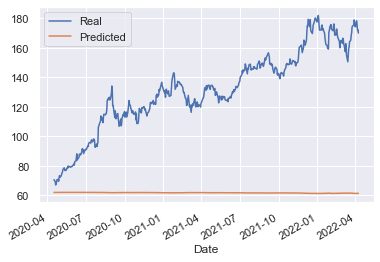

In [42]:
aapl_stock.plot()